In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
import joblib
import os

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data = pd.read_csv(url, sep=";")

In [4]:
# Vista general de los datos
print(wine_data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [5]:
# Descripción estadística básica
print(wine_data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [6]:
# Comprobar valores faltantes
print(wine_data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


# Vista general de los datos y estadísticas descriptivas
## Vista general de los datos:
Las primeras filas del dataset revelan que hay una mezcla de características químicas tanto continuas como discretas que describen la calidad del vino. Esto incluye acidez, azúcar, dióxido de azufre, entre otros.
La variable objetivo, quality, es numérica y parece clasificar la calidad en una escala de 3 a 8 (posible escala 1-10 donde no hay casos por debajo de 3 ni por encima de 8).

## Estadísticas descriptivas:
Las características como fixed acidity, volatile acidity, citric acid, y chlorides muestran una variación considerable, lo que sugiere diferentes perfiles de vino.
El alcohol tiene un rango que va desde 8.4 hasta 14.9, lo que es significativo y podría influir fuertemente en la percepción de calidad.
No hay valores faltantes en el dataset, lo que facilita el análisis y la modelización sin la necesidad de imputar datos.

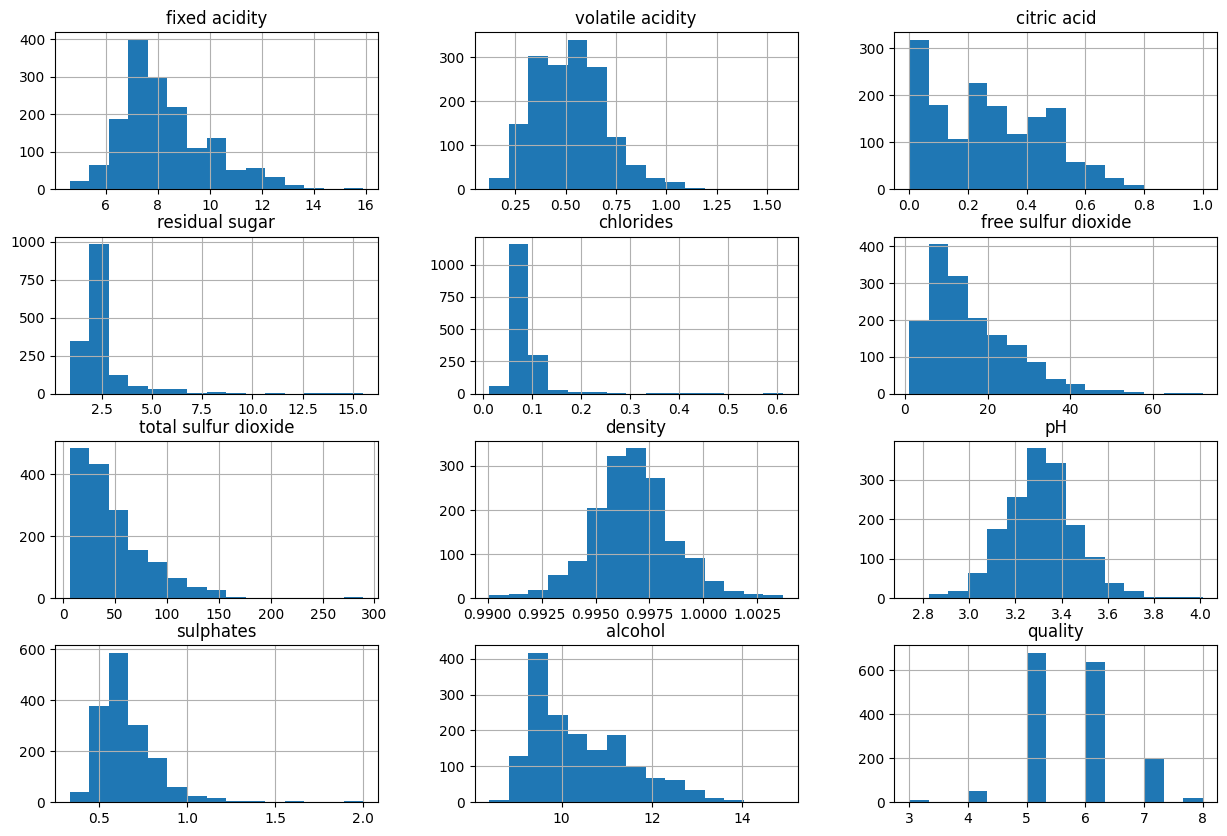

In [12]:
# Histogramas para todas las características
wine_data.hist(bins=15, figsize=(15, 10))
plt.show()

## Análisis de Histogramas:
"Acidez fija y volátil": Ambas presentan distribuciones con una ligera asimetría hacia la derecha, lo que indica que hay vinos con niveles más altos de lo común.

'Ácido cítrico': La mayoría de los vinos tienen bajo contenido de ácido cítrico, con una distribución que decrece a medida que aumenta el contenido.

'Azúcar residual': La mayoría de los vinos tienen bajos niveles de azúcar residual, con una notable asimetría hacia la derecha.

'Dióxido de azufre libre y total': Ambos tienen distribuciones sesgadas hacia la derecha, con algunos valores extremadamente altos que podrían ser outliers.

'Densidad y pH': Estas características muestran distribuciones más simétricas, indicando una variabilidad menos extrema.

'Sulfatos': Distribución sesgada hacia la derecha, similar a las observaciones de ácido y azúcar.

'Alcohol': Tiene una distribución multi-modal, lo que puede reflejar diferentes tipos de vino dentro del dataset.

'Calidad': La mayoría de los vinos están calificados entre 5 y 6, con menos vinos de calidades muy altas o bajas.

## Conclusiones Iniciales
+ Las distribuciones de muchas variables presentan asimetría, lo que podría requerir transformaciones durante la fase de preparación de datos para modelar.
+ El análisis de outliers será crucial, especialmente para variables como sulfatos y dióxido de azufre, donde algunos valores son muy altos.
+ La calidad del vino muestra una concentración en las categorías medias, con pocas observaciones en los extremos. Esto podría dificultar la modelización de vinos de muy alta o muy baja calidad sin técnicas de balanceo o ajuste de datos.

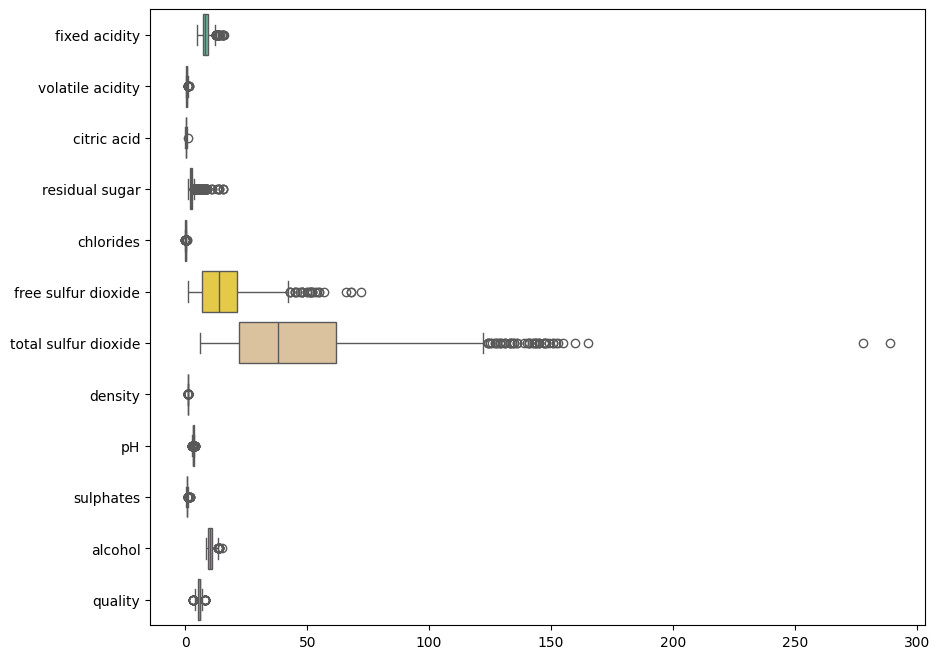

In [9]:
# Boxplots para ver distribuciones y posibles outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=wine_data, orient="h", palette="Set2", ax=ax)
plt.show()

# ANálisis de Boxplots
1. Acidez fija (Fixed Acidity)
Distribución relativamente simétrica con pocos valores atípicos. Esto indica que la mayoría de los vinos tienen una cantidad de acidez fija dentro de un rango estrecho, con excepciones mínimas.
2. Acidez volátil (Volatile Acidity)
La mediana está bien centrada, pero hay una cantidad considerable de outliers. La acidez volátil alta puede afectar negativamente la calidad del vino, siendo estos valores atípicos de particular interés.
3. Ácido cítrico (Citric Acid)
Pocos outliers, con la mayoría de los valores concentrados en un rango inferior. Esto sugiere que el ácido cítrico no varía mucho entre la mayoría de los vinos, excepto en unos pocos casos.
4. Azúcar residual (Residual Sugar)
Hay varios valores atípicos extremos. Esto podría indicar vinos específicos con niveles de dulzura mucho más altos, posiblemente vinos de postre o especializados.
5. Cloruros (Chlorides)
Muchos valores atípicos indican que mientras la mayoría de los vinos tienen un nivel bajo de cloruros, algunos contienen cantidades significativamente mayores, lo que podría impactar en el sabor y la conservación.
6. Dióxido de azufre libre (Free Sulfur Dioxide)
Esta variable muestra una dispersión amplia de outliers, lo que sugiere que el manejo del SO2 es variable en la vinificación. Altos niveles pueden ser usados para evitar la oxidación y el crecimiento de bacterias.
7. Dióxido de azufre total (Total Sulfur Dioxide)
Similar al dióxido de azufre libre, pero con una concentración más notable de outliers. La gestión de estos niveles es crucial para la calidad del vino.
8. Densidad (Density)
Muy pocas variaciones y sin outliers significativos, indicando consistencia en esta propiedad entre diferentes vinos.
9. pH
Distribución bastante uniforme sin outliers prominentes, mostrando que el pH de los vinos tiende a ser bastante controlado y dentro de un rango estrecho.
10. Sulfatos (Sulphates)
Algunos outliers sugieren variaciones en el uso de sulfatos, que son aditivos comunes en la vinificación para influir en el sabor y la fermentación.
11. Alcohol
Pocos valores atípicos, con una distribución más amplia. El alcohol es un componente central del vino, y su variación puede reflejar diferencias en estilo y cuerpo.
12. Calidad (Quality)
Los boxplots de calidad muestran que hay una variación de calidad entre los vinos, con un rango notable entre las calificaciones más bajas y más altas.

## Conclusión y Recomendaciones
Atención a Outliers: Es crucial investigar los valores atípicos en variables como cloruros y azúcares residuales, ya que pueden señalar características únicas o problemas en la producción del vino.
Equilibrio y Control: El control sobre variables como el pH y la densidad parece ser bueno, pero puede ser beneficioso explorar más a fondo las prácticas que llevan a la variabilidad en otras como los sulfatos y la acidez volátil.

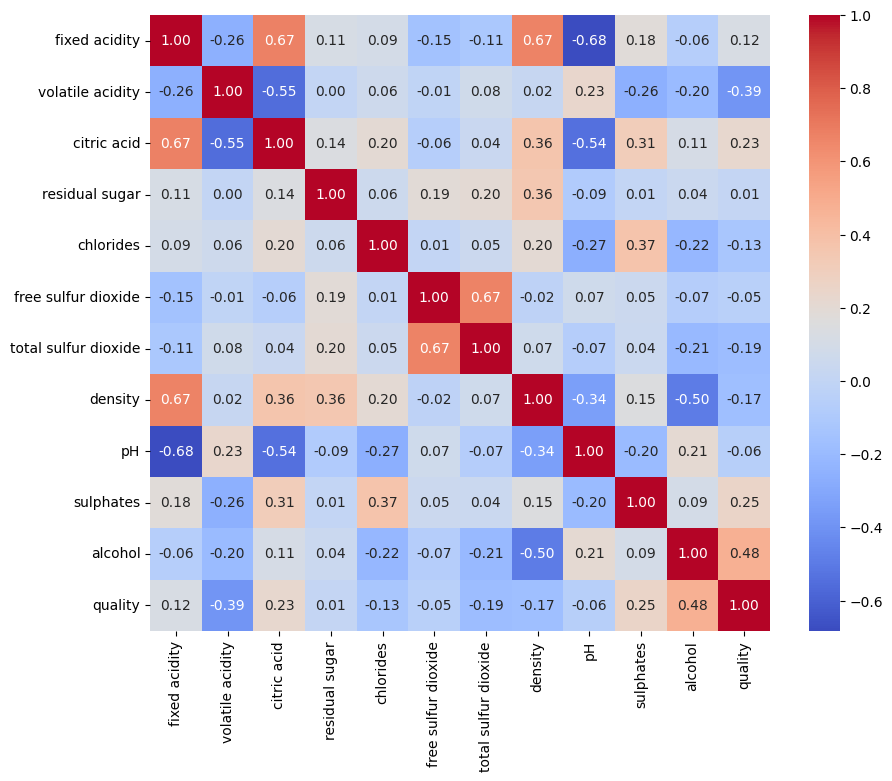

In [10]:
# Matriz de correlación
corr_matrix = wine_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

## Correlaciones Significativas
Acidez fija y ácido cítrico (0.67):
Existe una fuerte correlación positiva, lo cual es lógico ya que ambos están relacionados con la acidez total del vino.

Acidez volátil y calidad (-0.39):
La acidez volátil tiene una correlación negativa moderada con la calidad, indicando que altos niveles de acidez volátil podrían estar asociados con una menor calidad del vino.

Ácido cítrico y pH (-0.54):
Una relación inversa notable, ya que el aumento en el ácido cítrico tiende a bajar el pH (haciendo el vino más ácido).

Dióxido de azufre libre y total (0.67):
Esta correlación positiva es esperada porque el dióxido de azufre libre es parte del total.

Densidad y alcohol (-0.50):
Una fuerte correlación negativa, lo que se alinea con el hecho de que al aumentar el alcohol, la densidad del vino generalmente disminuye.

Calidad y alcohol (0.48):
Existe una correlación positiva moderada, sugiriendo que un mayor contenido de alcohol puede estar asociado con una mayor calidad del vino, posiblemente debido a una mejor percepción de cuerpo y estructura en el paladar.

## Otras Observaciones
pH y acidez fija (-0.68):
Una fuerte correlación negativa que indica que a medida que la acidez fija aumenta, el pH disminuye (más acidez).

Densidad y acidez fija (0.67):
Una correlación positiva fuerte, ya que una mayor acidez fija podría contribuir a un incremento en la densidad.

Sulfatos y calidad (0.25):
Una correlación positiva modesta que sugiere un impacto positivo de los sulfatos en la calidad del vino, posiblemente debido a su rol en la prevención de la oxidación y mejora de sabores.

## Implicaciones para el Modelado
### Selección de Características:
Variables con fuertes correlaciones con la calidad, como el alcohol y la acidez volátil, son candidatos prometedores para ser incluidos en modelos predictivos.

### Multicolinealidad:
Debe prestarse atención a las variables altamente correlacionadas, como acidez fija y ácido cítrico, para evitar problemas de multicolinealidad en modelos de regresión.

### Transformaciones y Escalado:
Dado el impacto significativo de ciertas variables sobre la calidad, podrían considerarse transformaciones (por ejemplo, logarítmicas) para aquellas con distribuciones sesgadas o para normalizar relaciones.

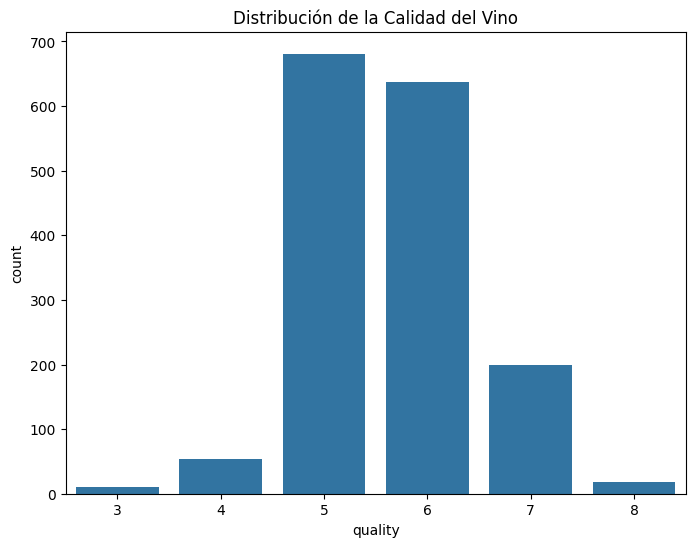

In [11]:
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=wine_data)
plt.title('Distribución de la Calidad del Vino')
plt.show()

## Análisis de la Distribución de la Calidad del Vino
### Observaciones de la Distribución
La gráfica muestra la distribución de la calidad del vino en una escala de 3 a 8. Los puntos claves son:

### Moda en las Calificaciones:
La mayoría de los vinos están calificados con 5 y 6. Estos representan las categorías más comunes en el dataset.

### Calificaciones Extremas:
Hay pocos vinos con calificaciones extremadamente altas (8) o bajas (3). Esto puede introducir un sesgo en cualquier modelo predictivo, ya que tendrá menos ejemplos de estos casos para aprender.

### Distribución Desigual:
Las calificaciones de 7 y 4 también son relativamente menos comunes que las de 5 y 6, pero más comunes que los extremos de 3 y 8.

In [14]:
# Tratemiento de outliers
for column in wine_data.columns:
    if wine_data[column].dtype == 'float64' or wine_data[column].dtype == 'int64':
        percentiles = wine_data[column].quantile([0.01, 0.99]).values
        wine_data[column] = np.clip(wine_data[column], percentiles[0], percentiles[1])


In [15]:
# Normalización de variables
scaler = MinMaxScaler()
wine_data_scaled = scaler.fit_transform(wine_data.drop('quality', axis=1))
wine_data_scaled = pd.DataFrame(wine_data_scaled, columns=wine_data.columns[:-1])
wine_data_scaled['quality'] = wine_data['quality']

In [16]:
# Dividir datos en conjuntos de entrenamiento y de prueba
X = wine_data_scaled.drop('quality', axis=1)
y = wine_data_scaled['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Definir modelo y búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_sa

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [19]:
# Entrenar modelo con mejores hiperparámetros
best_params = grid_search.best_params_
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [20]:
# EValuación del modelo
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           4       0.00      0.00      0.00        11
           5       0.70      0.76      0.73       130
           6       0.59      0.67      0.63       132
           7       0.56      0.36      0.43        42
           8       0.00      0.00      0.00         5

    accuracy                           0.63       320
   macro avg       0.37      0.36      0.36       320
weighted avg       0.60      0.63      0.61       320

Accuracy: 0.634375


/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Análisis
Los resultados de la evaluación del modelo Random Forest indican algunas áreas clave para mejorar. Específicamente, la capacidad del modelo para clasificar correctamente las calificaciones de calidad más altas y más bajas (4, 8) es limitada, lo cual es común en clases con pocos ejemplos de entrenamiento. 

In [24]:
# Mapeo original de etiquetas
label_mapping = {4:0, 5:1, 6:2, 7:3, 8:4}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Aplicar el mapeo al conjunto de datos
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

In [25]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenamiento del modelo usando las etiquetas mapeadas
xgb_model.fit(X_train, y_train_mapped)

# Predicciones y re-mapeo a las etiquetas originales
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_original = pd.Series(y_pred_xgb).map(inverse_label_mapping).values

# Evaluación usando etiquetas originales
print(classification_report(y_test, y_pred_xgb_original))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_original))

              precision    recall  f1-score   support

           4       1.00      0.09      0.17        11
           5       0.68      0.76      0.72       130
           6       0.57      0.62      0.60       132
           7       0.59      0.40      0.48        42
           8       0.00      0.00      0.00         5

    accuracy                           0.62       320
   macro avg       0.57      0.38      0.39       320
weighted avg       0.62      0.62      0.61       320

Accuracy: 0.621875


In [27]:
# Búsqueda de hiperparámetros
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train_mapped)
best_params_xgb = grid_search_xgb.best_params_

# Entrenar con los mejores parámetros
xgb_best = XGBClassifier(**best_params_xgb)
xgb_best.fit(X_train, y_train_mapped)

# Evaluación final
y_pred_best_xgb = xgb_best.predict(X_test)
print(classification_report(y_test_mapped, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test_mapped, y_pred_best_xgb))


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END 

/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Análisis de los Resultados
### Mejora en el rendimiento: 
XGBoost ha mostrado una mejora general en la precisión (accuracy) del modelo del 62% al 67.5%, lo cual es positivo.

### Problemas con clases minoritarias: 
Ambos modelos tienen problemas con las clases menos representadas (las calificaciones 4 y 8), lo que se refleja en los bajos valores de precisión y recall para estas clases. Este es un problema común en datasets desbalanceados.

In [30]:
# Aplicar SMOTE y ajustar el classweight en el XGBoost
# Crear el objeto SMOTE
smote = SMOTE()

# Crear y configurar el modelo XGBoost con ajuste de class_weight
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # Ajustar según la necesidad específica
    random_state=42
)

# Crear un pipeline con SMOTE y XGBoost
pipeline = make_pipeline(smote, xgb_model)

# Entrenar el modelo usando el pipeline
pipeline.fit(X_train, y_train_mapped)

# Evaluación
y_pred_pipeline = pipeline.predict(X_test)
print(classification_report(y_test_mapped, y_pred_pipeline))
print("Accuracy:", accuracy_score(y_test_mapped, y_pred_pipeline))


/home/vscode/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:17:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.30      0.55      0.39        11
           1       0.74      0.67      0.70       130
           2       0.64      0.62      0.63       132
           3       0.54      0.62      0.58        42
           4       0.17      0.20      0.18         5

    accuracy                           0.63       320
   macro avg       0.48      0.53      0.50       320
weighted avg       0.65      0.63      0.64       320

Accuracy: 0.63125


Vamos a abordar los problemas encontrados:
+ Mantenemos el SMOTE
+ Ajustamos los pesos directamente

In [33]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_mapped)

# Calcular los pesos de clase para las nuevas clases balanceadas por SMOTE
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_smote), y=y_train_smote)
weight_map = dict(zip(np.unique(y_train_smote), class_weights))
weights = y_train_smote.map(weight_map)

In [34]:
# Configuración del modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenamiento del modelo con sample_weight
xgb_model.fit(X_train_smote, y_train_smote, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
# Validación cruzada y ajuste de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote, sample_weight=weights)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.05, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=2)

In [36]:
# Mejor modelo y evaluación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test_mapped, y_pred))
print("Accuracy:", accuracy_score(y_test_mapped, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.18      0.19        11
           1       0.74      0.74      0.74       130
           2       0.68      0.67      0.68       132
           3       0.58      0.62      0.60        42
           4       0.20      0.20      0.20         5

    accuracy                           0.67       320
   macro avg       0.48      0.48      0.48       320
weighted avg       0.67      0.67      0.67       320

Accuracy: 0.66875


## Reflexión sobre el Rendimiento del Modelo
### Mejora en Clases Minoritarias: 
Los esfuerzos por balancear el entrenamiento con SMOTE y el ajuste de pesos parecen haber tenido un impacto positivo en las clases menos representadas, aunque sigue siendo modesto.
### Consistencia en Clases Mayoritarias: 
La precisión y recall para las clases mayoritarias son bastante estables y muestran un buen rendimiento.

##### Dada la naturaleza de la práctica, consideramos el modelo válido y procedemos a guardarlo y a crear la aplicación FLASK

In [39]:
# Guardar el modelo
model_path = '../models/wine_quality_model.pkl'
joblib.dump(best_model, model_path)

print(f"Modelo guardado correctamente en {model_path}")

Modelo guardado correctamente en ../models/wine_quality_model.pkl


In [4]:
# Establecer el camino al directorio donde se guardará el archivo HTML
template_dir = os.path.join(os.getcwd(), 'templates')

# Crear el directorio 'templates' si no existe
if not os.path.exists(template_dir):
    os.makedirs(template_dir)

# Camino al archivo 'index.html'
html_file_path = os.path.join(template_dir, 'index.html')

In [5]:
# Contenido HTML que se escribirá en 'index.html'
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Wine Quality Prediction</title>
    <style>
        body { font-family: Arial, sans-serif; background-color: #f4f4f9; color: #333; }
        h2 { color: #5a5a5a; }
        .container { width: 90%; margin: 20px auto; padding: 20px; background: white; border-radius: 8px; box-shadow: 0 0 10px rgba(0,0,0,0.1); }
        label { margin-top: 10px; display: block; }
        input, button { width: 95%; padding: 10px; margin-top: 5px; border: 1px solid #ddd; border-radius: 5px; }
        button { background-color: #5c67f2; color: white; border: none; cursor: pointer; }
        button:hover { background-color: #5058e5; }
        .prediction { margin-top: 20px; color: #31708f; background-color: #d9edf7; border-color: #bce8f1; padding: 10px; border-radius: 5px; }
    </style>
</head>
<body>
    <div class="container">
        <h2>Wine Quality Prediction</h2>
        <form action="/predict" method="post">
            <label for="fixed_acidity">Fixed Acidity:</label>
            <input type="text" id="fixed_acidity" name="fixed_acidity" required>

            <label for="volatile_acidity">Volatile Acidity:</label>
            <input type="text" id="volatile_acidity" name="volatile_acidity" required>

            <label for="citric_acid">Citric Acid:</label>
            <input type="text" id="citric_acid" name="citric_acid" required>

            <label for="residual_sugar">Residual Sugar:</label>
            <input type="text" id="residual_sugar" name="residual_sugar" required>

            <label for="chlorides">Chlorides:</label>
            <input type="text" id="chlorides" name="chlorides" required>

            <label for="free_sulfur_dioxide">Free Sulfur Dioxide:</label>
            <input type="text" id="free_sulfur_dioxide" name="free_sulfur_dioxide" required>

            <label for="total_sulfur_dioxide">Total Sulfur Dioxide:</label>
            <input type="text" id="total_sulfur_dioxide" name="total_sulfur_dioxide" required>

            <label for="density">Density:</label>
            <input type="text" id="density" name="density" required>

            <label for="pH">pH:</label>
            <input type="text" id="pH" name="pH" required>

            <label for="sulphates">Sulphates:</label>
            <input type="text" id="sulphates" name="sulphates" required>

            <label for="alcohol">Alcohol:</label>
            <input type="text" id="alcohol" name="alcohol" required>

            <button type="submit">Predict Quality</button>
        </form>
        {% if prediction_text %}
            <div class="prediction">Predicted Quality: {{ prediction_text }}</div>
        {% endif %}
    </div>
</body>
</html>
"""
# Escribir el contenido al archivo 'index.html'
with open(html_file_path, 'w') as html_file:
    html_file.write(html_content)

print(f"Archivo 'index.html' creado con éxito en {html_file_path}")

Archivo 'index.html' creado con éxito en /workspaces/machine-learning-python-template/src/templates/index.html
